# Solution to the system
----

### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import time
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
%matplotlib inline

### The system of equations

In [2]:
def opioid(state, t, alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star):
    S, P, A, R = state
    S_prime = -alpha*S - beta*(1-xi)*S*A - beta*xi*S*P + epsilon*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (epsilon + gamma + mu)*P
    A_prime = gamma*P + sigma*R + beta*(1-xi)*S*A + beta*xi*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    return [S_prime, P_prime, A_prime, R_prime]

### Our modified version

In [3]:
def opioid(state, t, alpha, beta_1, beta_2, gamma, zeta, delta, sigma, mu, mu_star):
    
    '''epsilon was defined to be the prescribed to susceptible rate, but has the
    constraint that it is equal to 1 - gamma.
    
    delta is defined to be the rate of recovery, and is assumed to be 1 - sigma - nu*A
    '''
    S, P, A, R = state
    nu = (1 - sigma - delta)/A
    S_prime = -alpha*S - beta_1*S*A - beta_2*S*P + (1-gamma)*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (1 + mu)*P
    A_prime = gamma*P + sigma*R + beta_1*S*A + beta_2*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    return [S_prime, P_prime, A_prime, R_prime]

### Our best guesses for parameters

In [32]:
# parameters
epsilon = 0.74 # Prescribed to Susceptible rate
gamma = 0.26 # rate of addiction among prescribed users
gamma = 0.08
sigma = 0.7 # natural relapse rate of R 
mu = 0.00824 # death rate
mu_star = 0.00834 # death rate of addicts
mu_star = 0.023 #0.0235275 what I think it should be
delta = 0.6 # R to S rate. 0.1 is default
beta_1 = 0.0625 # total addiction rate for Susceptible due to illegal access
beta_2 = 0.0625 # total addiction rate for Susceptible due to illegal access
alpha = 0.3 # prescription rate. could be 0-1
zeta = 0.7 # rate of A entry into rehab. could be 0-1

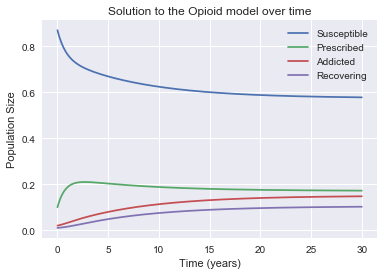

In [38]:
# times to solve at
t = np.linspace(0, 30, 300)
# initial state
state0 = [0.87, 0.1, 0.02, 0.01]
numerical_sol, output = sp.integrate.odeint(opioid, state0, t, full_output=1,args=(alpha, beta_1, beta_2, gamma, zeta, nu, sigma, mu, mu_star))
S = numerical_sol[:,0]
P = numerical_sol[:,1]
A = numerical_sol[:,2]
R = numerical_sol[:,3]

plt.plot(t, S, label="Susceptible")
plt.plot(t, P, label= "Prescribed")
plt.plot(t, A, label= "Addicted")
plt.plot(t, R, label= "Recovering")
plt.title("Solution to the Opioid model over time")
plt.xlabel("Time (years)")
plt.ylabel("Population Size")
plt.legend()
plt.savefig('opioid_solution.png')

In [36]:
output

{'hu': array([ 0.03795706,  0.03795706,  0.1036712 ,  0.1036712 ,  0.07776801,
         0.07776801,  0.07776801,  0.07776801,  0.07776801,  0.11290232,
         0.11290232,  0.11290232,  0.11290232,  0.11290232,  0.11290232,
         0.11290232,  0.11290232,  0.17117179,  0.17117179,  0.17117179,
         0.17117179,  0.17117179,  0.17117179,  0.17117179,  0.17117179,
         0.17117179,  0.17117179,  0.17117179,  0.17117179,  0.19458198,
         0.19458198,  0.19458198,  0.19458198,  0.19458198,  0.19458198,
         0.19458198,  0.19458198,  0.19458198,  0.19458198,  0.19458198,
         0.19458198,  0.19458198,  0.19556462,  0.19556462,  0.19556462,
         0.19556462,  0.19556462,  0.19556462,  0.19556462,  0.19556462,
         0.19556462,  0.19556462,  0.19556462,  0.19556462,  0.19556462,
         0.19556462,  0.25220845,  0.25220845,  0.25220845,  0.25220845,
         0.25220845,  0.25220845,  0.25220845,  0.25220845,  0.25220845,
         0.25220845,  0.25220845,  0.25220845

### Function to return final addiction states given input parameter values

### Perform sensitivity analysis - Sensitivity to parameters

In [183]:
# Run model (example)
Y = getFinalAddiction(param_values)

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=False)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)

In [184]:
results = pd.DataFrame({
    "parameter": ['alpha', 'beta_1', 'beta_2', 'gamma', 'zeta', 'delta', 'sigma', 'mu', 'mu_star'],
    "first-order effect": Si['S1'].round(3),
    "total-order effect": Si['ST'].round(3)
})
#Si['S1']
results.sort(columns="first-order effect", ascending=False)

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,first-order effect,parameter,total-order effect
4,0.838,zeta,0.854
1,0.070,beta_1,0.100
3,0.034,gamma,0.048
0,0.025,alpha,0.037
8,0.012,mu_star,0.011
2,0.002,beta_2,0.005
5,0.000,delta,0.000
6,0.000,sigma,0.000
7,-0.000,mu,0.000


In [126]:
results

array([ 0.039,  0.031,  0.002,  0.027,  0.793,  0.   ,  0.   , -0.   ,
        0.001])